# Analysis of unithood

This notebook contains most parts of the analysis on unithood, the strength of association between components of concepts.

In [1]:
import utils  # a python module in the same dir as the notebooks
import seaborn as sns

In [4]:
CORPUS_NAME = 'acl'
MODEL_NAME = CORPUS_NAME + ''
MODEL_SPEC = '_all'
FREQ_THRESHOLD = 2

INCLUDE_MESH_TERMS = False
FILTER_STOP_WORDS = True
FILTER_PUNCTUATION = True

In [5]:
import os
os.chdir(utils.ROOT)  # get to the root directory of the project

from datautils import dataio, annotations as anno
from stats import ngramcounting

# load the corpus
print('Loading n-gram model', flush=True)
model = ngramcounting.NgramModel.load_model(MODEL_NAME, MODEL_SPEC)

if CORPUS_NAME.lower() == 'pmc':
    corpus = dataio.load_craft_corpus() + dataio.load_genia_corpus()
else:
    corpus = dataio.load_corpus(CORPUS_NAME.lower())

Loading n-gram model


Loading ACL 2.0 corpus: 100%|██████████| 300/300 [00:00<00:00, 605.45it/s]


## Question 1: How strong is the association in regular concepts?

In [6]:
# get all continuous concepts

from stats import conceptstats
cont_concepts = conceptstats.gold_standard_concepts(corpus, discontinuous=False)

Retrieving gold standard concepts ... Skipped 0 concepts not bounded at tokens boundaries and filtered out 0 with the POS-tag filter: None


In [7]:
len(cont_concepts)

2479

In [8]:
import nltk
concept_bigrams = {bigram for concept in cont_concepts for bigram in nltk.bigrams(concept)}

In [9]:
if INCLUDE_MESH_TERMS:
    concept_bigrams.update(
    {bigram for concept in dataio.load_mesh_terms()
     for bigram in nltk.bigrams(concept)}
    )
if FILTER_STOP_WORDS:
    stopwords = set(nltk.corpus.stopwords.words('english'))
    concept_bigrams = {bg for bg in concept_bigrams
                      if not (bg[0] in stopwords or bg[1] in stopwords)}
if FILTER_PUNCTUATION:
    import string
    punct = string.punctuation
    concept_bigrams = {bg for bg in concept_bigrams
                      if not (bg[0] in punct or bg[1] in punct)}

In [10]:
import pandas as pd
import math

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'in_concept': [],  'pmi': [], 'll': [], 'tc': [], 'dice': [], 'combo': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(count)
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    tc = conceptstats.term_coherence(bigram, model)
    data_dict['tc'].append(tc)
    dice = conceptstats.term_coherence(bigram, model) / math.log10(count)
    data_dict['dice'].append(dice)
    combo = pmi + math.log10(count) * 2
    data_dict['combo'].append(combo)
    
    data_dict['in_concept'].append(bigram in concept_bigrams)


data = pd.DataFrame(data_dict)

In [11]:
sum(data.freq)

17765

In [12]:
# number of bigram types:
print('Outside:', len(data[data['in_concept'] == False]))
print('Inside:', len(data[data['in_concept'] == True]))

Outside: 3499
Inside: 594


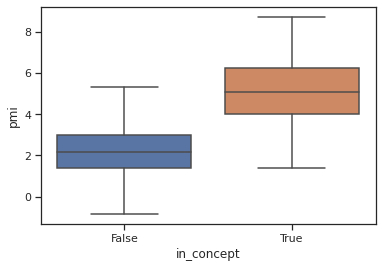

In [13]:
import seaborn as sns
sns.boxplot(x='in_concept', y='pmi', data=data, showfliers=False)

In [14]:
print(utils.prepare_comparable_latex_boxplots('in_concept', 'pmi', data))

\begin{axis}[boxplot/draw direction=y, xtick={1, 2}, xticklabels={False, True}]
\addplot+ [boxplot prepared={lower whisker=-0.86, lower quartile=1.40, median=2.11, upper quartile=2.86, upper whisker=5.31}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=1.41, lower quartile=4.01, median=5.09, upper quartile=6.24, upper whisker=8.74}] coordinates {};
\end{axis}


In [ ]:
data[(data['in_concept'] == True)].sort_values('combo', ascending=False).head(10)
#  & (data['pmi'] < 0)

In [ ]:
import re
csv_string = data[(data['in_concept'] == False)  & (data['pmi'] < 4)].sort_values('pmi', ascending=False).tail(10).to_csv(sep='&')
csv_string = csv_string.replace('&True', '')
csv_string = csv_string.replace("('", '')
csv_string = csv_string.replace("')", '')
csv_string = csv_string.replace("', '", ' ')
csv_string = csv_string.replace('\n', '\\\\\n')
csv_string = re.sub('\n\d+&', '\n', csv_string)
csv_string = csv_string.replace('&', '\t& ')
print(csv_string)

In [ ]:
data[(data['in_concept'] == True)].sort_values('ll', ascending=False).head(10)

In [ ]:
# we can perform t-tests etc.
import pingouin

In [ ]:
t_test_result = pingouin.ttest(list(data[data['in_concept'] == True]['pmi']),
               list(data[data['in_concept'] == False]['pmi']),
               correction=True)

In [ ]:
t_test_result

In [ ]:
pingouin.compute_effsize_from_t(t_test_result['T'][0],
                                nx=len(list(data[data['in_concept'] == True]['pmi'])),
                                ny=len(list(data[data['in_concept'] == False]['pmi'])),
                                eftype='cles')

In [ ]:
pingouin.mwu(list(data[data['in_concept'] == True]['ll']),
             list(data[data['in_concept'] == False]['ll']))

In [ ]:
sns.lmplot('dice', 'tc', data)

In [ ]:
data.sort_values('tc')[(data['pmi'] > 8)]

In [ ]:
conceptstats.ngram_pmi('training', 'data', model)

Conclusion: concept bigrams _do_ have higher association.

## Question 2: How does it look for bigrams in DC's?

In [ ]:
disc_concepts = conceptstats.gold_standard_concepts(corpus, continuous=False,
                                                    discontinuous=True)


In [ ]:
# extra dc's: skipgrams from CC's which are also CC's and hence a valid DC
if False:
    extra_dcs = set()
    for concept in cont_concepts:
        count = 0
        for sg in set(ngramcounting.make_skipgrams(concept)).difference(
            ngramcounting.make_ngrams(concept)):
            if sg in cont_concepts:
                print(concept, '-->', sg)
                extra_dcs.add(sg)
    disc_concepts.update(extra_dcs)

In [ ]:
dc_bigrams = {bigram for concept in disc_concepts for bigram in nltk.bigrams(concept)}

In [ ]:
if FILTER_STOP_WORDS:
    stopwords = set(nltk.corpus.stopwords.words('english'))
    dc_bigrams = {bg for bg in dc_bigrams
                  if not (bg[0] in stopwords or bg[1] in stopwords)}
if FILTER_PUNCTUATION:
    import string
    punct = string.punctuation
    dc_bigrams = {bg for bg in dc_bigrams
                  if not (bg[0] in punct or bg[1] in punct)}

In [ ]:
import pandas as pd
import nltk

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'type': [],  'pmi': [], 'll': [], 'tc': [], 'dice': [], 'combo': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    
    if bigram in concept_bigrams:
        if bigram in dc_bigrams:
            bigram_type = 'both'
        else:
            bigram_type = 'only_CC'
    elif bigram in dc_bigrams:
        #continue
        bigram_type = 'only_DC'
    else:
        bigram_type = 'neither'
    data_dict['type'].append(bigram_type)
    
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(math.log10(count))
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    tc = conceptstats.term_coherence(bigram, model)
    data_dict['tc'].append(tc)
    dice = tc / math.log10(count)
    data_dict['dice'].append(dice)
    combo = pmi + math.log10(count)
    data_dict['combo'].append(combo)


data = pd.DataFrame(data_dict)

In [ ]:
data

In [ ]:
sns.boxplot(x='type', y='freq', data=data, showfliers=False)

In [ ]:
print(utils.prepare_comparable_latex_boxplots('type', 'freq', data))

In [ ]:
sns.scatterplot(x='pmi', y='freq', hue='type', data=data)

In [ ]:
pingouin.homoscedasticity(data, 'pmi', 'type')

In [ ]:
pingouin.qqplot(list(data[data['type'] == 'only_CC']['pmi']))

In [ ]:
pingouin.welch_anova(data, 'dice', 'type')

In [ ]:
pairwise = pingouin.pairwise_gameshowell(data, 'pmi', 'type', effsize='CLES')#.to_csv(sep='&')

In [ ]:
pairwise

In [ ]:
csv_string = pairwise.drop(columns=['mean(A)', 'mean(B)', 'se', 'tail', 'df']).to_csv(sep='&')
csv_string = csv_string.replace('\n', '\\\\\n')
csv_string = re.sub('\n\d+&', '\n', csv_string)
csv_string = csv_string.replace('&', '\t& ')
print(csv_string)

In [ ]:
pingouin.compute_effsize_from_t(86.845, nx=len(list(data[data['type'] == 'neither']['pmi'])),
                                ny=len(list(data[data['type'] == 'only_CC']['pmi'])), eftype='cles')

In [ ]:
data[data['type'] == 'both'].sort_values('pmi', ascending=False).head(20)

In [ ]:
{bg for bg in data[data['type'] == 'only_CC']['bigram'] if bg[0] == 'bone'}

In [ ]:
sns.boxplot(x='type', y='tc', data=data, showfliers=False)

In [ ]:
print(utils.prepare_comparable_latex_boxplots('type', 'll', data))

In [ ]:
# However, notice that
len(data[data['type'] == 'only_DC'])

In [ ]:
# compared to e.g.
len(data[data['type'] == 'both'])

## Question 3: What is the association across the gap?

In [ ]:
from collections import defaultdict
from itertools import product

gap_bigrams = defaultdict(list)
cont_bigrams = defaultdict(list)
dc_sample = {dc for doc in corpus for dc in doc.get_annotations(anno.DiscontinuousConcept)}
for dc in dc_sample:
    tokens = dc.get_tokens()
    norm_concept = dc.normalized_concept()
    spanned_tokens = dc.get_spanned_tokens()
    non_dc_tokens = set(spanned_tokens).difference(tokens)
    for t in non_dc_tokens:
        if t.mapped_pos() == 'c':
            cc = t
            break
    for i in range(len(tokens) - 1):
        t1, t2 = tokens[i], tokens[i+1]
        bigram = norm_concept[i:i + 2]
        if t2.span[0] - t1.span[-1] > 2:
            gap_bigrams[bigram].append(dc)

        else:
            cont_bigrams[bigram].append(dc)

In [ ]:
data_dict = {'bigram': [], 'freq': [], 'pmi': [], 'll': [], 'tc': [], 'combo': [], 'type': [], 'in_concept': []}

all_bigrams = set.union(set(gap_bigrams.keys()), set(cont_bigrams.keys()))
for bigram in all_bigrams:
    # skip if not frequent enough
    if model.freq(bigram) < FREQ_THRESHOLD:
        continue

    data_dict['bigram'].append(bigram)
    count = model.freq(bigram)
    data_dict['freq'].append(math.log10(count))

    contingency_table = model.contingency_table(bigram[0], bigram[1], smoothing=1)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    tc = conceptstats.term_coherence(bigram, model)
    data_dict['tc'].append(tc)
    combo = pmi + math.log10(count)
    data_dict['combo'].append(combo)

    # how it occurs
    if bigram in gap_bigrams:
        if bigram in cont_bigrams: 
            type_ = 'both'
        else:
            type_ = 'only_gap'
    elif bigram in cont_bigrams:
        type_ = 'only_cont'
    else:
        type_ = 'weird'

    data_dict['type'].append(type_)
    
    data_dict['in_concept'].append(bigram in concept_bigrams)

data = pd.DataFrame(data_dict)

### NOTE

That a bigram occurs as `only_gap` means that it occurs only in gap position for DC's. However, those bigrams can just as well occur in CC's as well, thereby getting a high association.

In [ ]:
sns.boxplot(x='type', y='freq', data=data, showfliers=False)

In [ ]:
print(utils.prepare_comparable_latex_boxplots('type', 'freq', data))

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [ ]:
sns.scatterplot(x='pmi', y='freq', hue='type', data=data)
sns.lineplot(x=[-2, 10], y=[1.7, 1.7])
sns.lineplot(x=[1.5, 1.5], y=[0, 5])
sns.lineplot(x=[-1, 0, 1], y=[2 ,1, 0])

In [ ]:
math.log10(50)

In [ ]:
len(data[data['combo'] < 1]) / len(data)

In [ ]:
print(utils.prepare_comparable_latex_boxplots('type', 'pmi', data))

In [ ]:
len(data[data['type'] == 'only_gap'])

In [ ]:
pingouin.homoscedasticity(data, 'combo', 'type')

In [ ]:
pingouin.welch_anova(data, 'combo', 'type')

In [ ]:
pairwise = pingouin.pairwise_gameshowell(data, 'combo', 'type', effsize='cles')

In [ ]:
pairwise

In [ ]:
csv_string = pairwise.drop(columns=['mean(A)', 'mean(B)', 'se', 'tail', 'df']).to_csv(sep='&')
csv_string = csv_string.replace('\n', '\\\\\n')
csv_string = re.sub('\n\d+&', '\n', csv_string)
csv_string = csv_string.replace('&', '\t& ')
print(csv_string)

In [ ]:
sns.boxplot(x='type', y='ll', data=data, showfliers=False)

In [ ]:
sns.boxplot(x='type', y='tc', data=data, showfliers=False)

In [ ]:
sns.boxplot(x='type', y='freq', data=data, showfliers=False)

## Question 4: What is the full-term unithood?

In [ ]:
all_concepts = disc_concepts.union(cont_concepts)

In [ ]:
data_dict = {'concept': [], 'type': [],  'pmi_nl': [], 'tc': [], 'freq': [], 'len': []}

for concept in all_concepts:
    
    if model[concept] < FREQ_THRESHOLD:
        continue
    
    data_dict['concept'].append(concept)
    
    data_dict['freq'].append(model[concept])
    
    if concept in disc_concepts:
        if concept in cont_concepts:
            concept_type = 'both'
        else:
            concept_type = 'only_DC'
    else:
        concept_type = 'only_CC'
    data_dict['type'].append(concept_type)
    
    data_dict['pmi_nl'].append(conceptstats.length_normalized_pmi(concept, model))
    data_dict['tc'].append(conceptstats.term_coherence(concept, model))
    
    data_dict['len'].append(len(concept))


data = pd.DataFrame(data_dict)

In [ ]:
data.sort_values('tc', ascending=False).head(50)

In [ ]:
len(data[(data['pmi_nl'] < 2) & (data['len'] == 2)]) / len(data)

In [ ]:
sns.boxplot(x='type', y='freq', data=data, showfliers=False)

In [ ]:
data_dict = {'ngram': [], 'freq': [], 'type': [], 'tc': [], 'pmi': [], 'pmi_nl': [], 'len': []}

for n in range(2, 11):
    for ngram, count in model.iterate(n, FREQ_THRESHOLD):
        
        ngram = tuple(ngram.split())

        data_dict['ngram'].append(ngram)

        data_dict['freq'].append(model[ngram])

        if ngram in disc_concepts:
            if ngram in cont_concepts:
                ngram_type = 'both'
            else:
                ngram_type = 'only_DC'
        elif ngram in cont_concepts:
            ngram_type = 'only_CC'
        else:
            ngram_type = 'neither'
            
        data_dict['type'].append(ngram_type)

        data_dict['pmi'].append(conceptstats.length_normalized_pmi(ngram, model) * (len(ngram) - 1))
        data_dict['pmi_nl'].append(conceptstats.length_normalized_pmi(ngram, model))
        data_dict['tc'].append(conceptstats.term_coherence(ngram, model))

        data_dict['len'].append(len(ngram))
        
data = pd.DataFrame(data_dict)

In [ ]:
sns.boxplot(x='type', y='pmi_nl', data=data, showfliers=False)

In [ ]:
print(utils.prepare_comparable_latex_boxplots('len', 'pmi_nl', data))